In [6]:
import numpy as np
#!pip install xarray
#!pip install xmitgcm
#!pip install zarr
#!pip install aiohttp
import dask.array as da

import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import aiohttp
warnings.filterwarnings('ignore')

#3D plot
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10,10)

In [7]:
## read in 3D data from public portal (you don't have to download!)
model = llcreader.ECCOPortalLLC2160Model()

In [8]:
## get Theta
ds_sst = model.get_dataset(varnames=['Theta'], type='latlon')
ds_sst

<xarray.Dataset> Size: 377TB
Dimensions:  (face: 13, i: 8640, i_g: 8640, j: 6480, j_g: 6480, k: 90, k_u: 90,
              k_l: 90, k_p1: 91, time: 18679)
Coordinates: (12/47)
  * face     (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 69kB 0 1 2 3 4 5 6 ... 8633 8634 8635 8636 8637 8638 8639
  * i_g      (i_g) int64 69kB 0 1 2 3 4 5 6 ... 8634 8635 8636 8637 8638 8639
  * j        (j) int64 52kB 0 1 2 3 4 5 6 ... 6473 6474 6475 6476 6477 6478 6479
  * j_g      (j_g) int64 52kB 0 1 2 3 4 5 6 ... 6474 6475 6476 6477 6478 6479
  * k        (k) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    ...       ...
    XG       (j_g, i_g) float32 224MB dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    YG       (j_g, i_g) float32 224MB dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    dxV      (j_g, i_g) float32 224MB dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    dyU      (j_g, i_g) float32 224MB dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    Zl       (k_l) >f4 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zu       (k_u) >f4 360B dask.array<chunksize=(90,), meta=np.ndarray>
Data variables:
    Theta    (time, k, j, i) float32 376TB dask.array<chunksize=(1, 1, 6480, 2160), meta=np.ndarray>

# look around miami
25.7617° N, 80.1918° W

In [9]:
subset2 = ds_sst.isel(time=-1,j=slice(4550,4750),i=slice(7550,7800),k=slice(0,90))

import dask.array as da

# Compute the data to convert it from Dask array to NumPy array
computed_data = subset2.Theta.data.compute()

# Create the DataArray with fully loaded data
array2 = xr.DataArray(
    computed_data,
    dims=['depth', 'lat', 'lon'],
    coords={
        'depth': subset2.Z.data,
        'lat': subset2.YC[:, 0].data,
        'lon': subset2.XC[0, :].data
    }
)

#array2 = xr.DataArray(subset2.Theta.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
#array2 = array2.load()

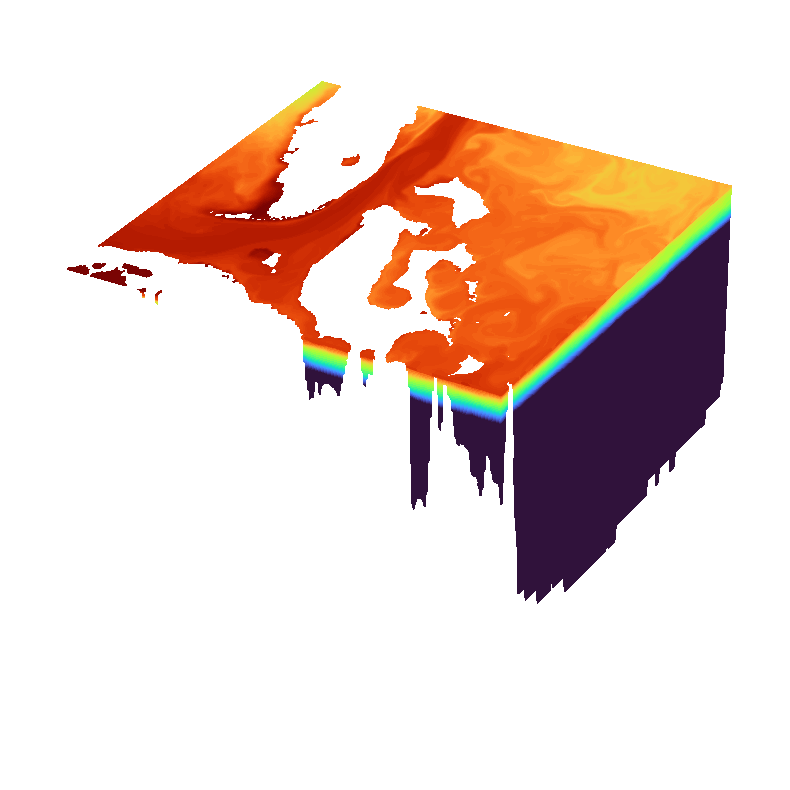

In [10]:
z_cut = array2.isel(depth=0).data
x_cut = array2.isel(lon=-1).data 
y_cut = array2.isel(lat=0).data 
xx = array2.lon
yy = array2.lat
zz = array2.depth

z_cut.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap,vmin,vmax='turbo',12,28

#offset is used to shift it to the top of the cube
X,Y=np.meshgrid(xx,yy)
ax.contourf(X,Y,z_cut,60,zdir='z',offset=zz[0],cmap=cmap,vmin=vmin,vmax=vmax)
Y,Z=np.meshgrid(yy,zz)
ax.contourf(x_cut,Y,Z,60,zdir='x',offset=xx[-1],cmap=cmap,vmin=vmin,vmax=vmax) 
X,Z=np.meshgrid(xx,zz)
ax.contourf(X,y_cut,Z,60,zdir='y',offset=yy[0],cmap=cmap,vmin=vmin,vmax=vmax)

#ax.set_frame_on(True)
ax.set_zlim(zz[-1],zz[0])
ax.set_xlim(xx[0],xx[-1])
ax.set_ylim(yy[0],yy[-1])
#ax.plot([xx[0],xx[-1]],[yy[0],yy[0]],zs=zz[0],zdir='z',color='k') #tried to add edge to contourf plots but shows up underneath

plt.savefig('../img/3D_miami.png')
ax._axis3don = False
plt.savefig('../img/3D_miami.png')

Text(0, 0.5, 'Theta (K)')

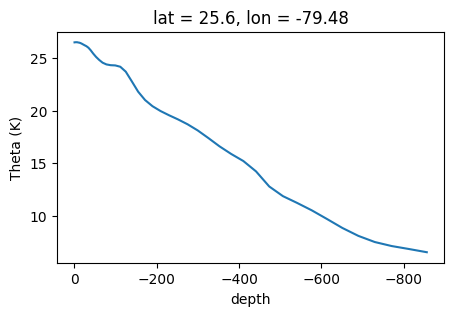

In [102]:
plt.figure(figsize=(5, 3))
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')#lat=25,lon=-80 or -79.5 and -79.8 both have good deep data
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
#ax=array2.sel(lat=25,lon=-80,method='nearest').plot(y='depth')
ax=down_data.plot(xincrease=False)
plt.ylabel('Theta (K)')

Text(0, 0.5, 'Theta (K)')

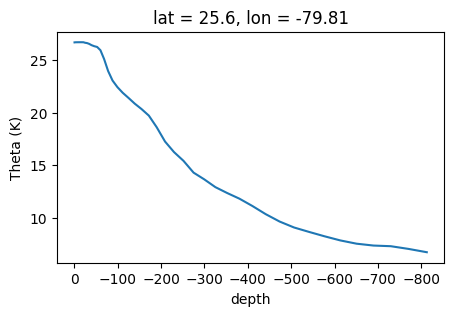

In [103]:
plt.figure(figsize=(5, 3))
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest') #alt loc: 25.602843, -79.879238 #original loc: (lat=25,lon=-79.5,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32
ax=up_data.plot(xincrease=False)
plt.ylabel('Theta (K)')

In [104]:
df_down_depth = pd.DataFrame(down_data["depth"])
df_up_depth = pd.DataFrame(up_data["depth"])
print(df_down_depth)

              0
0     -0.500000
1     -1.570000
2     -2.790000
3     -4.185000
4     -5.780000
..          ...
85 -5148.439941
86 -5498.725098
87 -5881.879883
88 -6301.185059
89 -6760.169922

[90 rows x 1 columns]


In [105]:
df_down_temp = pd.DataFrame(down_data)
df_up_temp = pd.DataFrame(up_data)
print(df_down_temp)

            0
0   26.478880
1   26.485657
2   26.489256
3   26.491455
4   26.491770
..        ...
85        NaN
86        NaN
87        NaN
88        NaN
89        NaN

[90 rows x 1 columns]


In [123]:
#merge temp and depth
df_down = pd.concat([df_down_depth, df_down_temp], axis=1)
df_down.columns = ['Depth', 'Temp']

first_nan_index = df_down['Temp'].isna().idxmax()
print(first_nan_index)
#trim
df_down = df_down.loc[:first_nan_index - 1]
print(df_down)

49
         Depth       Temp
0    -0.500000  26.478880
1    -1.570000  26.485657
2    -2.790000  26.489256
3    -4.185000  26.491455
4    -5.780000  26.491770
5    -7.595000  26.485592
6    -9.660000  26.463764
7   -12.010000  26.451021
8   -14.680000  26.415699
9   -17.705000  26.360773
10  -21.125000  26.286303
11  -24.990000  26.203730
12  -29.344999  26.115000
13  -34.240002  25.971563
14  -39.724998  25.730736
15  -45.855000  25.415348
16  -52.689999  25.101677
17  -60.279999  24.814419
18  -68.684998  24.549166
19  -77.964996  24.384521
20  -88.175003  24.311310
21  -99.370003  24.290134
22 -111.599998  24.164442
23 -124.915001  23.696087
24 -139.365005  22.793392
25 -154.990005  21.795576
26 -171.824997  21.000912
27 -189.899994  20.416412
28 -209.235001  19.960968
29 -229.854996  19.560379
30 -251.770004  19.164623
31 -274.984985  18.701517
32 -299.505005  18.119806
33 -325.320007  17.399378
34 -352.420013  16.611158
35 -380.790009  15.885591
36 -410.410004  15.212692
37 -441.2

In [124]:
#merge temp and depth
df_up = pd.concat([df_up_depth, df_up_temp], axis=1)
df_up.columns = ['Depth', 'Temp']
first_nan_index = df_up['Temp'].isna().idxmax()
print(first_nan_index)
#trim
df_up = df_up.loc[:first_nan_index - 1]
print(df_up)

48
         Depth       Temp
0    -0.500000  26.705711
1    -1.570000  26.712503
2    -2.790000  26.715128
3    -4.185000  26.716909
4    -5.780000  26.718323
5    -7.595000  26.719490
6    -9.660000  26.720453
7   -12.010000  26.721188
8   -14.680000  26.721561
9   -17.705000  26.721155
10  -21.125000  26.718300
11  -24.990000  26.668854
12  -29.344999  26.640303
13  -34.240002  26.564808
14  -39.724998  26.442490
15  -45.855000  26.344471
16  -52.689999  26.268923
17  -60.279999  25.957493
18  -68.684998  25.121054
19  -77.964996  23.976833
20  -88.175003  23.070601
21  -99.370003  22.444557
22 -111.599998  21.905151
23 -124.915001  21.416605
24 -139.365005  20.868975
25 -154.990005  20.353748
26 -171.824997  19.730597
27 -189.899994  18.625650
28 -209.235001  17.255474
29 -229.854996  16.254272
30 -251.770004  15.418172
31 -274.984985  14.295467
32 -299.505005  13.657600
33 -325.320007  12.912215
34 -352.420013  12.353483
35 -380.790009  11.811847
36 -410.410004  11.121306
37 -441.2

In [125]:
df_up_reversed = df_up.loc[::-1].reset_index(drop=True)
print(df_up_reversed)

         Depth       Temp
0  -812.659973   6.712388
1  -770.585022   7.027701
2  -729.594971   7.285825
3  -689.684998   7.348125
4  -650.854980   7.524999
5  -613.109985   7.837746
6  -576.465027   8.234755
7  -540.934998   8.650712
8  -506.540009   9.070245
9  -473.304993   9.635894
10 -441.255005  10.339461
11 -410.410004  11.121306
12 -380.790009  11.811847
13 -352.420013  12.353483
14 -325.320007  12.912215
15 -299.505005  13.657600
16 -274.984985  14.295467
17 -251.770004  15.418172
18 -229.854996  16.254272
19 -209.235001  17.255474
20 -189.899994  18.625650
21 -171.824997  19.730597
22 -154.990005  20.353748
23 -139.365005  20.868975
24 -124.915001  21.416605
25 -111.599998  21.905151
26  -99.370003  22.444557
27  -88.175003  23.070601
28  -77.964996  23.976833
29  -68.684998  25.121054
30  -60.279999  25.957493
31  -52.689999  26.268923
32  -45.855000  26.344471
33  -39.724998  26.442490
34  -34.240002  26.564808
35  -29.344999  26.640303
36  -24.990000  26.668854
37  -21.1250

In [127]:
first_row_down = df_down.iloc[-1]

# Extract the first row from df_up
first_row_up = df_up_reversed.iloc[0]

# Create a new DataFrame with these two rows
df_pause = pd.DataFrame([first_row_down, first_row_up])

# Reset the index if needed to make sure index 0 corresponds to df_down and index 1 to df_up
df_pause = df_pause.reset_index(drop=True)

print(df_pause)

        Depth      Temp
0 -855.835022  6.554811
1 -812.659973  6.712388


# Interpolation

.interp(n=5400)  #first part (going down)
.interp(n=100)  #second part (pause)  
.interp(n=1700)  #third part (going up)  



In [166]:
# Create a new index that represents the 5400 data points
# Number of original intervals
num_intervals = len(df_down) - 1  # 48 intervals

# Target number of rows
target_rows = 5400

# Calculate the step size per interval
step_size = (target_rows - 1) / num_intervals  # Steps needed between each pair of points

print(f"Step size between each interval: {step_size}")

Step size between each interval: 112.47916666666667


In [167]:
interpolated_rows = []  # To store the new interpolated rows
cumulative_steps = 0  # Keep track of cumulative steps

# Iterate through each interval
for i in range(num_intervals):
    start = df_down.iloc[i]
    end = df_down.iloc[i + 1]
    
    # Calculate the number of steps (including integer and fractional parts)
    cumulative_steps += step_size
    steps = int(cumulative_steps)
    cumulative_steps -= steps  # Keep the fractional part for the next iteration
    
    # Linear interpolation between the start and end point
    for j in range(steps):
        fraction = j / steps if steps > 0 else 0
        interpolated_depth = start['Depth'] + fraction * (end['Depth'] - start['Depth'])
        interpolated_temp = start['Temp'] + fraction * (end['Temp'] - start['Temp'])
        interpolated_rows.append([interpolated_depth, interpolated_temp])

# Add the last row of the original dataset
interpolated_rows.append(df_down.iloc[-1].tolist())

# Convert to DataFrame
df_down_interpolated = pd.DataFrame(interpolated_rows, columns=['Depth', 'Temp'])

# Ensure we have exactly 5400 rows
df_down_interpolated = df_down_interpolated.iloc[:target_rows]

print(df_down_interpolated)
print(f"Length of interpolated DataFrame: {len(df_down_interpolated)}")

           Depth       Temp
0      -0.500000  26.478880
1      -0.509554  26.478940
2      -0.519107  26.479001
3      -0.528661  26.479061
4      -0.538214  26.479122
...          ...        ...
5395 -854.306702   6.565560
5396 -854.688782   6.562872
5397 -855.070862   6.560185
5398 -855.452942   6.557498
5399 -855.835022   6.554811

[5400 rows x 2 columns]
Length of interpolated DataFrame: 5400


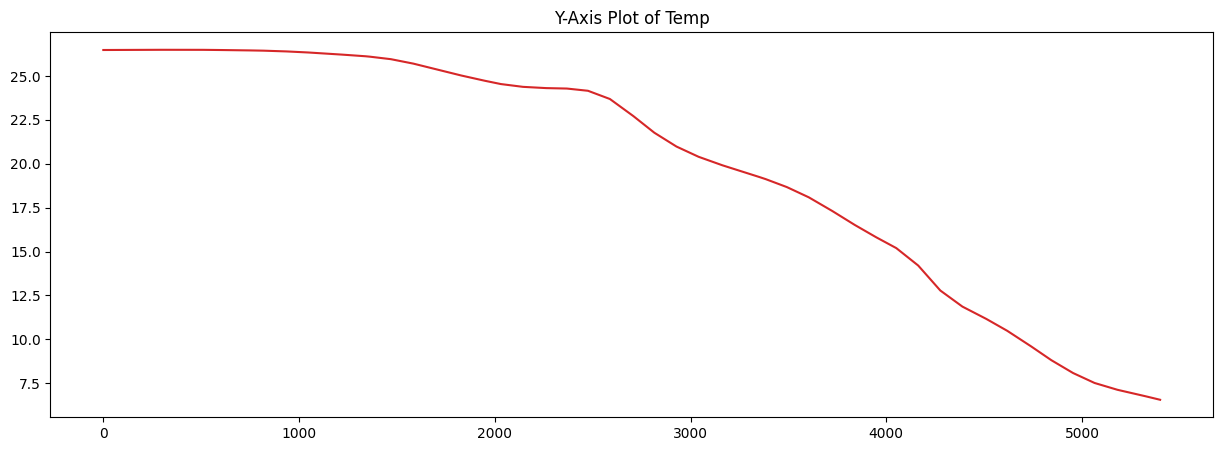

In [169]:
plt.figure(figsize=(15, 5))
plt.plot(df_down_interpolated.index, df_down_interpolated['Temp'], color='tab:red')
# Show the plot
plt.title('Y-Axis Plot of Temp')
plt.show()

In [170]:
# Create a new index that represents the 5400 data points
# Number of original intervals
num_intervals = len(df_up_reversed) - 1  # 48 intervals

# Target number of rows
target_rows = 1700

# Calculate the step size per interval
step_size = (target_rows - 1) / num_intervals  # Steps needed between each pair of points

print(f"Step size between each interval: {step_size}")

Step size between each interval: 36.148936170212764


In [171]:
interpolated_rows = []  # To store the new interpolated rows
cumulative_steps = 0  # Keep track of cumulative steps

# Iterate through each interval
for i in range(num_intervals):
    start = df_up_reversed.iloc[i]
    end = df_up_reversed.iloc[i + 1]
    
    # Calculate the number of steps (including integer and fractional parts)
    cumulative_steps += step_size
    steps = int(cumulative_steps)
    cumulative_steps -= steps  # Keep the fractional part for the next iteration
    
    # Linear interpolation between the start and end point
    for j in range(steps):
        fraction = j / steps if steps > 0 else 0
        interpolated_depth = start['Depth'] + fraction * (end['Depth'] - start['Depth'])
        interpolated_temp = start['Temp'] + fraction * (end['Temp'] - start['Temp'])
        interpolated_rows.append([interpolated_depth, interpolated_temp])

# Add the last row of the original dataset
interpolated_rows.append(df_up_reversed.iloc[-1].tolist())

# Convert to DataFrame
df_up_interpolated = pd.DataFrame(interpolated_rows, columns=['Depth', 'Temp'])

# Ensure we have exactly 5400 rows
df_up_interpolated = df_up_interpolated.iloc[:target_rows]

print(df_up_interpolated)
print(f"Length of interpolated DataFrame: {len(df_up_interpolated)}")

           Depth       Temp
0    -812.659973   6.712388
1    -811.491225   6.721146
2    -810.322476   6.729905
3    -809.153727   6.738664
4    -807.984979   6.747422
...          ...        ...
1694   -0.618889  26.706466
1695   -0.589167  26.706277
1696   -0.559444  26.706089
1697   -0.529722  26.705900
1698   -0.500000  26.705711

[1699 rows x 2 columns]
Length of interpolated DataFrame: 1699


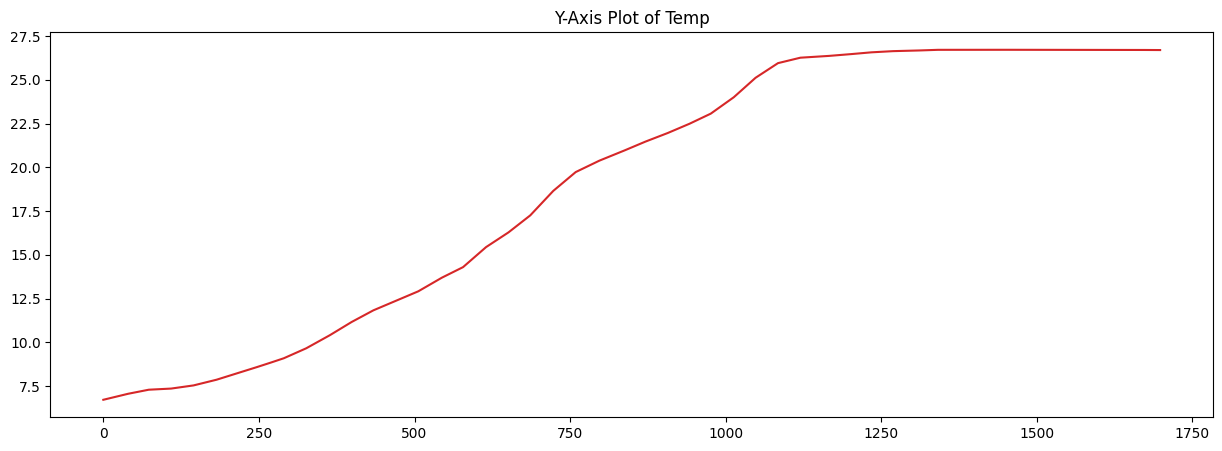

In [172]:
plt.figure(figsize=(15, 5))
plt.plot(df_up_interpolated.index, df_up_interpolated['Temp'], color='tab:red')
# Show the plot
plt.title('Y-Axis Plot of Temp')
plt.show()

In [178]:
# Number of original intervals
num_intervals = len(df_pause) - 1 

# Target number of rows
target_rows = 101

# Calculate the step size per interval
step_size = (target_rows - 1) / num_intervals  # Steps needed between each pair of points

print(f"Step size between each interval: {step_size}")

Step size between each interval: 100.0


In [179]:
interpolated_rows = []  # To store the new interpolated rows
cumulative_steps = 0  # Keep track of cumulative steps

# Iterate through each interval
for i in range(num_intervals):
    start = df_pause.iloc[i]
    end = df_pause.iloc[i + 1]
    
    # Calculate the number of steps (including integer and fractional parts)
    cumulative_steps += step_size
    steps = int(cumulative_steps)
    cumulative_steps -= steps  # Keep the fractional part for the next iteration
    
    # Linear interpolation between the start and end point
    for j in range(steps):
        fraction = j / steps if steps > 0 else 0
        interpolated_depth = start['Depth'] + fraction * (end['Depth'] - start['Depth'])
        interpolated_temp = start['Temp'] + fraction * (end['Temp'] - start['Temp'])
        interpolated_rows.append([interpolated_depth, interpolated_temp])

# Add the last row of the original dataset
interpolated_rows.append(df_pause.iloc[-1].tolist())

# Convert to DataFrame
df_pause_interpolated = pd.DataFrame(interpolated_rows, columns=['Depth', 'Temp'])

# Ensure we have exactly 5400 rows
df_pause_interpolated = df_pause_interpolated.iloc[:target_rows]

print(df_pause_interpolated)
print(f"Length of interpolated DataFrame: {len(df_pause_interpolated)}")

          Depth      Temp
0   -855.835022  6.554811
1   -855.403271  6.556386
2   -854.971521  6.557962
3   -854.539771  6.559538
4   -854.108020  6.561114
..          ...       ...
96  -814.386975  6.706084
97  -813.955225  6.707660
98  -813.523474  6.709236
99  -813.091724  6.710812
100 -812.659973  6.712388

[101 rows x 2 columns]
Length of interpolated DataFrame: 101


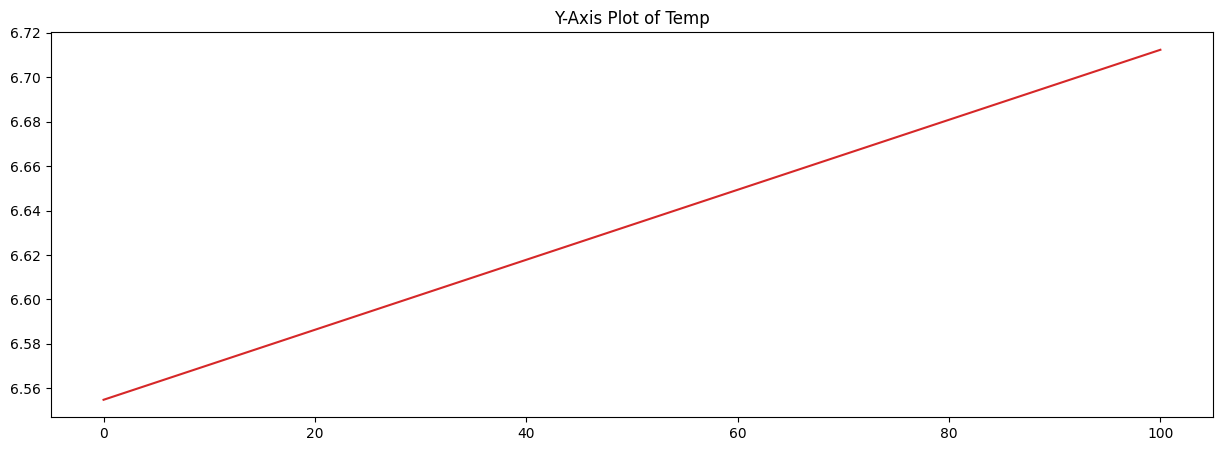

In [180]:
plt.figure(figsize=(15, 5))
plt.plot(df_pause_interpolated.index, df_pause_interpolated['Temp'], color='tab:red')
# Show the plot
plt.title('Y-Axis Plot of Temp')
plt.show()

In [181]:
# Concatenate the three DataFrames in the specified order
df_combined = pd.concat([df_down_interpolated, df_pause_interpolated, df_up_interpolated], axis=0)

# Reset the index to create a new continuous index
df_combined = df_combined.reset_index(drop=True)

# Display the combined DataFrame
print(df_combined)

         Depth       Temp
0    -0.500000  26.478880
1    -0.509554  26.478940
2    -0.519107  26.479001
3    -0.528661  26.479061
4    -0.538214  26.479122
...        ...        ...
7195 -0.618889  26.706466
7196 -0.589167  26.706277
7197 -0.559444  26.706089
7198 -0.529722  26.705900
7199 -0.500000  26.705711

[7200 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

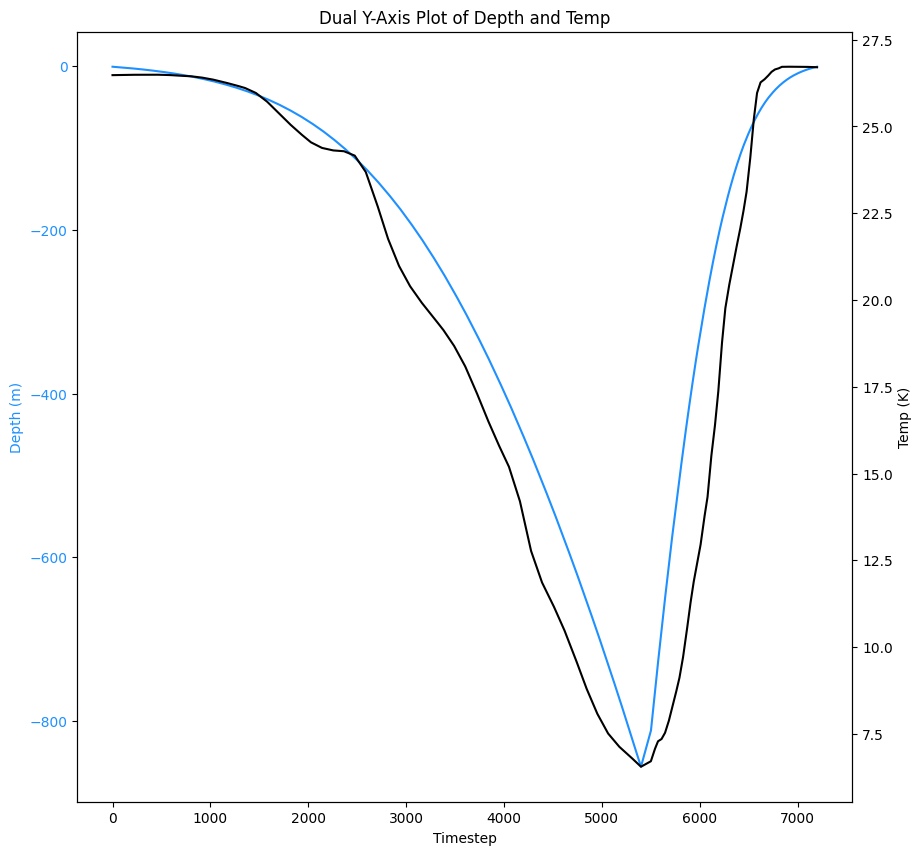

In [189]:
plt.figure(figsize=(15, 5))
fig, ax1 = plt.subplots()

# Plotting Depth on the first y-axis
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Depth (m)', color='dodgerblue')
ax1.plot(df_combined.index, df_combined['Depth'], color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Creating a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Temp (K)', color='black')
ax2.plot(df_combined.index, df_combined['Temp'], color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show the plot
plt.title('Dual Y-Axis Plot of Depth and Temp')
plt.savefig("../img/dive.pdf", format="pdf")
plt.show()

In [192]:
df_combined.to_csv("../data/dive.csv", index=True)